# Introduction to Data Science 
# Lecture 25: Neural Networks II
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

In this lecture, we'll continue discussing Neural Networks.

Recommended Reading:
* A. Géron, [Hands-On Machine Learning with Scikit-Learn & TensorFlow](http://proquest.safaribooksonline.com/book/programming/9781491962282) (2017) 
* I. Goodfellow, Y. Bengio, and A. Courville, [Deep Learning](http://www.deeplearningbook.org/) (2016)


In [1]:
import numpy as np
from sklearn.metrics import accuracy_score

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
#from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

## Recap: Neural Networks

Last time, we introduced *Neural Networks*, which can generally be used for supervised learning tasks, such as classification and regression.

There are many different *network architectures* for Nerual Networks, but we'll focus on **Multi-layer Perceptrons**. Here, there is an *input layer*, typically drawn on the left hand side and an *output layer*, typically drawn on the right hand side. The middle layers are sometimes called *hidden layers*. 


<img src="Colored_neural_network.svg" title="https://en.wikipedia.org/wiki/Artificial_neural_network#/media/File:Colored_neural_network.svg" 
width="300">


Given a set of features $X = \{x_1, x_2, ..., x_n\}$ and a target $y$, a neural network works as follows. Each neuron applies an affine transformation 
$$
x \mapsto w\cdot x + b
$$
and then a non-linear *activation function* $g\colon \mathbb R \to \mathbb R$. The composition looks like:
$$
x \mapsto g(w\cdot x + b).
$$
The output layer receives the values from the last hidden layer and transforms them into output values.

There are several choices of **activation function**: hyperbolic tangent, logistic, and rectified linear unit (ReLU). 



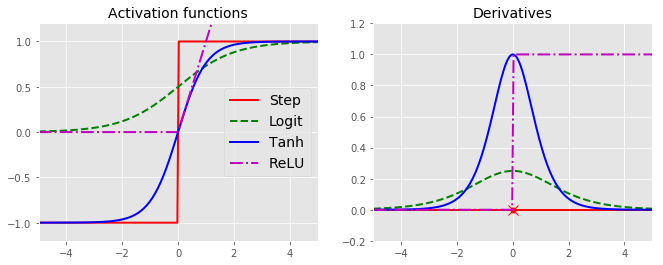

In [2]:
# see Géron, Ch. 10

def logit(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=2, label="Step")
plt.plot(z, logit(z), "g--", linewidth=2, label="Logit")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(logit, z), "g--", linewidth=2, label="Logit")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## Softmax function for classificaton 

The *softmax function*, $\sigma:\mathbb{R}^K \to (0,1)^K$ is defined by
$$
\sigma(\mathbf{z})_j = \frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}}
\qquad \qquad \textrm{for } j=1, \ldots, K.
$$
Note that each component is in the range $(0,1)$ and the values sum to 1. We interpret $\sigma(\mathbf{z})_j$ as the probability that $\mathbf{z}$ is a member of class $j$. 

## Training a neural network

Neural networks uses a loss function of the form 
$$
Loss(\hat{y},y,W) =  \frac{1}{2} \sum_{i=1}^n f(\hat{y}_i(W),y_i) + \frac{\alpha}{2} \|W\|_2^2
$$
Here, 
+ $y_i$ are the labels for the $i$-th example, 
+ $\hat{y}_i(W)$ are the predicted label for the $i$-th example, 
+ $f$ is a function that measures the error, typically $L^2$ difference for regression or cross-entropy for classification, and 
+ $\alpha$ is a regularization parameter. 

Starting from initial random weights, the loss function is minimized by repeatedly updating these weights. Various **optimization methods** can be used, *e.g.*, 
+ gradient descent method 
+ quasi-Newton method,
+ stochastic gradident descent, or 
+ adam. 

There are various parameters associated with each method that must be tuned. 

**Back propagation** is a way of using the chain rule from calculus to compute the gradient of the $Loss$ funtion for optimization. 

## Neural Networks in scikit-learn

Last time, we saw how both classification and regression can be done using Neural Networks in scikit-learn:
+ [multi-layer perceptron (MLP) classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)
+ [multi-layer perceptron (MLP) regressor](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)


## Neural networks with TensorFlow

Now let's see how you might use [TensorFlow](https://github.com/tensorflow/tensorflow) to train a Neural Network. 

### Installing TensorFlow

Instructions for installing TensorFlow are available at [the tensorflow install page](https://www.tensorflow.org/versions/r1.0/install/).

It is recommended that you use the command: 
```
sudo pip3 install --upgrade tensorflow
```

I used the command: 
```
sudo conda install -c conda-forge tensorflow
```

In [3]:
import tensorflow as tf
print(tf.__version__)

1.3.0


TensorFlow represents computations by connecting op (operation) nodes into a computation graph.

A TensorFlow program usually has two components:
+ In the *construction phase*, the computational graph is built
+ In the *execution phase*, the graph is run, which typically means there is a loop that iteratively optimizes the graph. 



In [4]:
# construction phase
x = tf.Variable(3)
y = tf.Variable(4)
f = x*x*y + y + 2

# execution phase
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    print(f.eval())

42


### Autodiff

TensorFlow can automatically compute the derivative of functions using [```gradients```](https://www.tensorflow.org/api_docs/python/tf/gradients). 

In [5]:
# construction phase
x = tf.Variable(3.0)
y = tf.Variable(4.0)
f = x + 2*y*y + 2
grads = tf.gradients(f,[x,y])

# execution phase
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # initializes all variables
    print([g.eval() for g in grads])


[1.0, 16.0]


This is enormously helpful since training a NN requires the derivate of the cost function with respect to the parameters. This is computed using backpropagation (chain rule) and TensorFlow does this work for you. 

**Exercise:** Use TensorFlow to compute the derivative of $f(x) = e^x$ at $x=2$.

In [6]:
# your code here

### Optimization methods
Tensorflow also has several built-in optimization methods.
+ [```GradientDescentOptimizer```](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer)

In [7]:
x = tf.Variable(3.0, trainable=True)
y = tf.Variable(2.0, trainable=True)
f = x*x + 100*y*y
opt = tf.train.GradientDescentOptimizer(learning_rate=5e-3).minimize(f)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        if i%100 == 0: print(sess.run([x,y,f]))
        sess.run(opt)
        

[3.0, 2.0, 409.0]
[1.0980968, 0.0, 1.2058167]
[0.40193906, 0.0, 0.16155501]
[0.14712274, 0.0, 0.021645101]
[0.053851694, 0.0, 0.0029000049]
[0.019711465, 0.0, 0.00038854184]
[0.0072150305, 0.0, 5.2056665e-05]
[0.0026409342, 0.0, 6.9745333e-06]
[0.00096666755, 0.0, 9.3444612e-07]
[0.00035383157, 0.0, 1.2519678e-07]


+ [```MomentumOptimizer```](https://www.tensorflow.org/api_docs/python/tf/train/MomentumOptimizer)

In [8]:
x = tf.Variable(3.0, trainable=True)
y = tf.Variable(2.0, trainable=True)
f = x*x + 100*y*y
opt = tf.train.MomentumOptimizer(learning_rate=1e-2,momentum=.5).minimize(f)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        if i%100 == 0: print(sess.run([x,y,f]))
        sess.run(opt)
        

[3.0, 2.0, 409.0]
[0.043930665, 2.0290405e-15, 0.0019299033]
[0.00061265659, -1.547466e-30, 3.7534809e-07]
[8.5441061e-06, 0.0, 7.300175e-11]
[1.1915596e-07, 0.0, 1.4198143e-14]
[1.6617479e-09, 0.0, 2.761406e-18]
[2.3174716e-11, 0.0, 5.3706746e-22]
[3.2319424e-13, 0.0, 1.0445451e-25]
[4.5072626e-15, 0.0, 2.0315416e-29]
[6.2858222e-17, 0.0, 3.9511561e-33]



+ [```tf.train.Optimizer```](https://www.tensorflow.org/api_docs/python/tf/train/Optimizer)
+ [```tf.train.GradientDescentOptimizer```](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer)
+ [```tf.train.AdadeltaOptimizer```](https://www.tensorflow.org/api_docs/python/tf/train/AdadeltaOptimizer)
+ [```tf.train.AdagradOptimizer```](https://www.tensorflow.org/api_docs/python/tf/train/AdagradOptimizer)
+ [```tf.train.AdagradDAOptimizer```](https://www.tensorflow.org/api_docs/python/tf/train/AdagradDAOptimizer)
+ [```tf.train.MomentumOptimizer```](https://www.tensorflow.org/api_docs/python/tf/train/MomentumOptimizer)
+ [```tf.train.AdamOptimizer```](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)
+ [```tf.train.FtrlOptimizer```](https://www.tensorflow.org/api_docs/python/tf/train/FtrlOptimizer)
+ [```tf.train.ProximalGradientDescentOptimizer```](https://www.tensorflow.org/api_docs/python/tf/train/ProximalGradientDescentOptimizer)
+ [```tf.train.ProximalAdagradOptimizer```](https://www.tensorflow.org/api_docs/python/tf/train/ProximalAdagradOptimizer)
+ [```tf.train.RMSPropOptimizer```](https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer)

For more information, see the [TensorFlow training webpage](https://www.tensorflow.org/api_guides/python/train). 


**Exercise:** Use TensorFlow to find the minimum of the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function): 
$$
f(x,y) = (x-1)^2 + 100*(y-x^2)^2.
$$


In [9]:
# your code here
        

## Classifying the MNIST handwritten digit dataset

We now classify the handwritten digits in the MNIST dataset. We'll follow Géron, Ch. 10 to build a NN using plain TensorFlow. 

In [11]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### Using plain TensorFlow

#### Construction phase

We specify the number of inputs and outputs and the size of each layer. Here the images are 28x28 and there are 10 classes (each corresponding to a digit). We'll choose 2 hidden layers, with 300 and 100 neurons respectively. 

Placeholder nodes are used to represent the training data and targets. We use the ```None``` keyword to leave the shape (of the training batch) unspecified. 

We add layers to the NN using the ```layers.dense()``` function. In each case, we specify the input, and the size of hte layer. We also specify the activation function used in each layer. Here, we choose the relu function. 

We specify that the output of the NN will be a softmax function. The loss function is cross entropy. 

We then specify that we'll use the [GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer)
with a learning rate of 0.01. 

Finally, we specify how the model will be evaluated. The [```in_top_k```](https://www.tensorflow.org/api_docs/python/tf/nn/in_top_k) function checks to see if the  targets are in the top k predictions. 

We then initialize all of the variables and create an object to save the model using the [```saver()```](https://www.tensorflow.org/programmers_guide/saved_model) function. 

#### Execution phase

At each *epoch*, the code breaks the training batch into mini-batches of size 50. Cycling thrugh the mini-batches, it uses gradient descent to train the NN. The accuracy for both the training and test datasets are evaluated.  


In [12]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y") 

# dnn
hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

# loss
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

# train
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01)
training_op = optimizer.minimize(loss)

# eval
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
save_path = "./my_model_final.ckpt"

n_epochs = 40
batch_size = 50

# Execution phase
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    save_path = saver.save(sess, save_path)


0 Train accuracy: 0.9 Test accuracy: 0.9053
1 Train accuracy: 0.94 Test accuracy: 0.9222
2 Train accuracy: 0.92 Test accuracy: 0.93
3 Train accuracy: 0.96 Test accuracy: 0.9372
4 Train accuracy: 0.94 Test accuracy: 0.9427
5 Train accuracy: 0.94 Test accuracy: 0.9473
6 Train accuracy: 0.98 Test accuracy: 0.95
7 Train accuracy: 0.96 Test accuracy: 0.9525
8 Train accuracy: 0.96 Test accuracy: 0.9576
9 Train accuracy: 0.94 Test accuracy: 0.9584
10 Train accuracy: 0.98 Test accuracy: 0.9624
11 Train accuracy: 0.94 Test accuracy: 0.9636
12 Train accuracy: 0.98 Test accuracy: 0.966
13 Train accuracy: 0.92 Test accuracy: 0.965
14 Train accuracy: 1.0 Test accuracy: 0.9679
15 Train accuracy: 1.0 Test accuracy: 0.9692
16 Train accuracy: 0.98 Test accuracy: 0.9693
17 Train accuracy: 0.96 Test accuracy: 0.9688
18 Train accuracy: 1.0 Test accuracy: 0.9714
19 Train accuracy: 1.0 Test accuracy: 0.9715
20 Train accuracy: 1.0 Test accuracy: 0.9722
21 Train accuracy: 1.0 Test accuracy: 0.9718
22 Train ac

Since the NN has been saved, we can use it for classification using the [```saver.restore```](https://www.tensorflow.org/programmers_guide/saved_model) function. 

This code loads 20 of the test images, classifies them, and then prints the predicted and actual classes. 

In [13]:
with tf.Session() as sess:
    saver.restore(sess, save_path)
    X_new_scaled = mnist.test.images[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)
    
print("Predicted classes:", y_pred)
print("Actual classes:   ", mnist.test.labels[:20])


INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
Predicted classes: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


We can also print the confusion matrix using [```confusion_matrix```](https://www.tensorflow.org/api_docs/python/tf/confusion_matrix). 

In [14]:
with tf.Session() as sess:
    saver.restore(sess, save_path)
    X_new_scaled = mnist.test.images
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)
    

from sklearn.metrics import confusion_matrix
print(confusion_matrix(mnist.test.labels,y_pred))


INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
[[ 969    0    0    2    2    2    1    1    2    1]
 [   0 1124    2    1    0    1    3    1    3    0]
 [   4    2 1009    1    2    0    1    8    5    0]
 [   0    0    3  991    0    4    0    6    4    2]
 [   3    0    3    0  958    0    3    4    1   10]
 [   2    1    0    8    1  868    6    1    3    2]
 [   5    2    1    1    4    5  939    0    1    0]
 [   0    5   10    3    0    0    0 1004    1    5]
 [   3    1    3    7    3    2    3    3  948    1]
 [   3    5    0    8    8    3    0    9    2  971]]


## Neural networks with Keras


### Installing Keras

[Keras](https://keras.io/) is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. We'll use it with TensorFlow. 

The installation page for Keras is [here](https://keras.io/#installation). I used the command 

```
sudo pip install keras
```

In [17]:
import keras
print(keras.__version__)

2.1.5


Using TensorFlow backend.


**Resources**:
[keras resource page](https://github.com/fchollet/keras-resources)


**Examples**:
[keras example page](https://github.com/keras-team/keras/blob/master/examples/README.md)

Let's look at how to train a NN using keras on the MNIST dataset. 

## keras example: MNIST

In [18]:
'''Trains a simple deep NN on the MNIST dataset.
Gets to 98.40% test accuracy after 20 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

batch_size = 128
num_classes = 10
epochs = 20

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

60000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [=======================

## Using a pretrained network

There are many more examples of NN on the examples page. Several of these take a long time (and are difficult) to train. So, let's use a pretrained network. 

It is also recommended that you use a pretrained network to initialize other networks for other applications. 

Following [this tutorial](http://www.learnopencv.com/keras-tutorial-using-pre-trained-imagenet-models/), we'll use a pretrained NN in keras for image recognition.

This NN was trained on the  [ImageNet](http://www.image-net.org/) project, which contains > 14 million images beloing to > 20,000 classes (synsets). 


In [19]:
import keras
import numpy as np
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions

#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet')

PIL image size (224, 224)


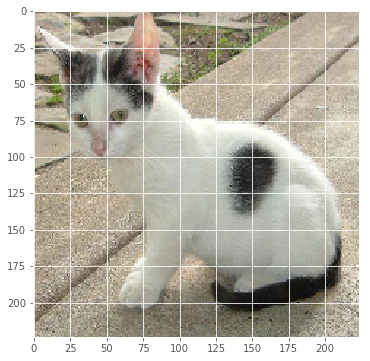

In [20]:
 # load an image in PIL format
original = load_img('images/cat.jpg', target_size=(224, 224))
print('PIL image size',original.size)
plt.imshow(original)
plt.show()

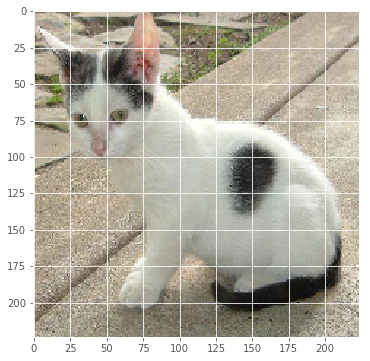

numpy array size (224, 224, 3)
image batch size (1, 224, 224, 3)


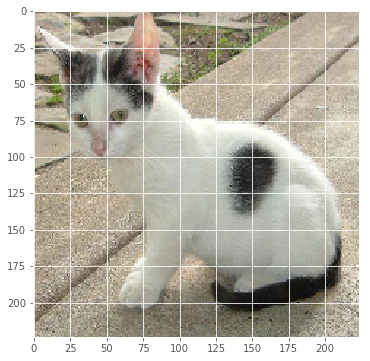

In [21]:
# convert the PIL image to a numpy array
# IN PIL - image is in (width, height, channel)
# In Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)
plt.imshow(np.uint8(numpy_image))
plt.show()
print('numpy array size',numpy_image.shape)
 
# Convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# We want the input matrix to the network to be of the form (batchsize, height, width, channels)
# Thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)
plt.imshow(np.uint8(image_batch[0]))

In [22]:
# prepare the image for the VGG model
processed_image = vgg16.preprocess_input(image_batch.copy())
 
# get the predicted probabilities for each class
predictions = vgg_model.predict(processed_image)
# print predictions
 
# convert the probabilities to class labels
# We will get top 5 predictions which is the default
label = decode_predictions(predictions)
print(label)

[[('n02123597', 'Siamese_cat', 0.21237043), ('n01877812', 'wallaby', 0.077764034), ('n02326432', 'hare', 0.071992479), ('n03223299', 'doormat', 0.057465978), ('n02124075', 'Egyptian_cat', 0.053032894)]]


**Exercise:** Repeat the above steps for a different image.

In [ ]:
# your code here

**Exercise:** There are several other pretrained networks for this dataset:

+ Inception_V3 model
+ ResNet50 model
+ MobileNet model

Try these! 


## CPU vs. GPU

[CPUs (Central processing units)](https://en.wikipedia.org/wiki/Central_processing_unit) have just a few cores. The number of processes that a CPU can do in parallel is limited. However, each cores is very fast and is good for sequential tasks. 

[GPUs (Graphics processing units)](https://en.wikipedia.org/wiki/Graphics_processing_unit) have thousands of cores, so can do many processes in parallel. GPU cores are typically slower and are more limited than CPU cores. However, for the right kind of computations (think matrix multiplication), GPUs are very fast. GPUs also have their own memory and caching systems, which further improves the speed of some computations, but also makes GPUs more difficult to program. (You have to use something like [CUDA](https://en.wikipedia.org/wiki/CUDA)).  

**Example:**

[Intel Core i9-7980XE CPU](https://www.amazon.com/Intel-Core-i9-7980XE-Processors-BX80673I97980X/dp/B075XRYMDR/ref=sr_1_1?ie=UTF8&qid=1523370424&sr=8-1&keywords=intel%2Bcore%2Bi9%2Bcpu&th=1)
+ 18 Cores/36 Threads
+ 4.40GHz
+ memory shared with system
+ $1892

[NVIDIA GeForce Titan X Pascal GPU](https://www.amazon.com/NVIDIA-GeForce-Pascal-GDDR5X-900-1G611-2500-000/dp/B01JLKP3IS/ref=pd_sbs_147_2?_encoding=UTF8&pd_rd_i=B01JLKP3IS&pd_rd_r=JDD3M5ZVSN81C8SYQ9XB&pd_rd_w=VjwmU&pd_rd_wg=cpVDS&psc=1&refRID=JDD3M5ZVSN81C8SYQ9XB)
+ 3072 Cores
+ 2.5GHz
+ 12GB Ram on card
+ $2000


TensorFlow and keras can use GPUs to significantly speed up the training NN. See the programmer's guide [here](https://www.tensorflow.org/programmers_guide/using_gpu). 

## More resources

+ Y. LeCun, Y. Bengio, and G. Hinton, [Deep learning](https://www.nature.com/articles/nature14539), Nature (2015). 
+ A. Géron, [Hands-On Machine Learning with Scikit-Learn & TensorFlow](http://proquest.safaribooksonline.com/book/programming/9781491962282) (2017) 
+ I. Goodfellow, Y. Bengio, and A. Courville, [Deep Learning](http://www.deeplearningbook.org/) (2016)


## Some challenges/competitions

+ The [CIFAR-10 dataset](https://en.wikipedia.org/wiki/CIFAR-10) consists of 60,000 32x32 color images in 10 classes (airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks) with 6,000 images per class. There are 50,000 training images and 10,000 test images. 

+ [ImageNet](http://image-net.org/about-overview) is an even larger image dataset and still growing. 
+ [Kaggle](https://www.kaggle.com/datasets) has multiple competitions on a wide variety of topics. 
+ Also, see more datasets on [this wikipedia page](https://en.wikipedia.org/wiki/List_of_datasets_for_machine_learning_research). 
